<a href="https://colab.research.google.com/github/lillianpoland/hi-class/blob/main/LillPolaU5proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 5 Project: Making a Generalized Linear Model (1 predictor)

In [156]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm

from scipy.interpolate import PchipInterpolator

In [157]:
#load the data into a pandas dataframe, and print it
url_football = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/football_players.csv'
#I could have put the url string directly into pd.read_csv()
football = pd.read_csv(url_football)

##Context:

The object of a football game is to score a goal on the opposing team's net. This must be done attempting a shot into the goal. There are many components that affect the probability of the ball making it into the net, such as the goalkeeper, defenders, and size of the goal, but we will just focus on the relationship between the shots taken and goals made.


Basically, imagine we are trying to guess how many goals a football player will score based on how many shots they take. The graphs that follow will help us make the best guess.


In [158]:
football

,name,position,goals,shots
0,Aaron Connolly,FW,5,59
1,Aaron Cresswell,DF,4,69
2,Aaron Hunt,MF,3,30
3,Aaron Lennon,MF,1,5
4,Aaron Leya Iseka,FW,10,76
...,...,...,...,...
2677,Óscar Mingueza,DF,2,12
2678,Óscar Plano,MF,12,124
2679,Óscar Rodríguez,MF,13,133
2680,Óscar Trejo,MF,1,20


<Axes: xlabel='shots', ylabel='goals'>

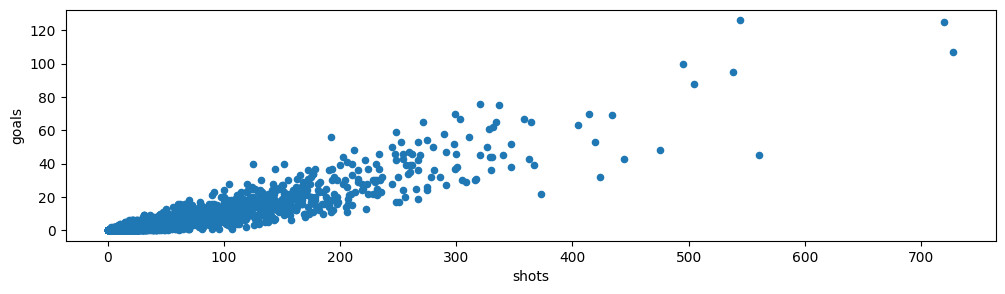

In [159]:
#scatter plot of thigh v. weight count of bikes
football.plot(x="shots", y="goals", figsize=(12, 3), kind="scatter")

##scatter plot analysis

This plot shows a bunch of dots, with each dot representing a football player. Their position on the graph shows how many shots they took and how many goals they scored. The dots up and to the right show us that players who take more shots tend to score more goals. Whereas the dots on the very bottom left show us that players who take no shots score no goals.

In [160]:
#lfb stands for linear football
with pm.Model() as model_lfb:

    #priors for the linear part of our model
    α = pm.Normal("α", mu=0, sigma=100)
    β = pm.Normal("β", mu=0, sigma=10)

    #this is the linear part of our model
    μ = pm.Deterministic("μ", α + β * football.shots)

    #prior for the standard deviation of our likelihood
    #Cauchy is a T dist with nu = 1
    σ = pm.HalfCauchy("σ", 10)

    #likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=football.goals)

    #inference data object
    idata_lfb = pm.sample()

Output()

Output()

Text(0, 0.5, 'goals')

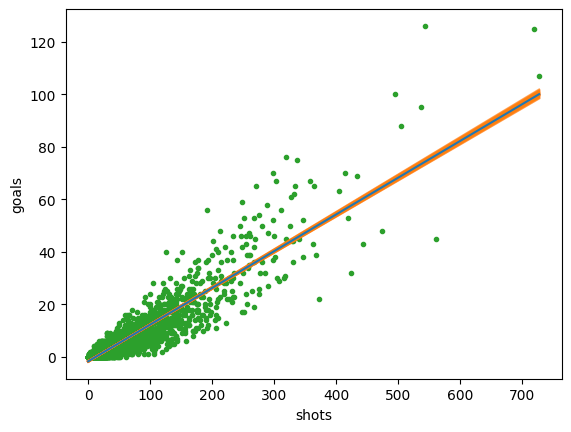

In [161]:
#grabs 100 posterior samples
posterior = az.extract(idata_lfb, num_samples=100)

# grabbing x values for graphing.
x_plot = xr.DataArray(
    np.linspace(football.shots.min(), football.shots.max(), 50),
    dims="plot_id"
    )

# this creates the expected line, the path we predict temperature and
#rented bike count deviates from
mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot

#These are a 50 lines that our model came up with
lines = posterior["α"] + posterior["β"] * x_plot

#set up plot
_, ax = plt.subplots()

#plots 50 other lines our model came up with.
ax.plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")

#plots the mean line
ax.plot(x_plot, mean_line, c="C0", label="mean line")

#plot the raw data
ax.plot(football.shots, football.goals, "C2.", zorder=-3)

#label axes and create legend
ax.set_xlabel("shots")
ax.set_ylabel("goals")

##Linear Model Analysis

The grey lines represent different guesses for the relaationship between shots and goals, whereas the blue line is the best guess of all of those (the average).

The blue line slope upward, telling us that (on average) as the number of shots taken by a player goes up, the number of goals scored also typically goes up. The dots are somewhat close to the lines, but there are a lot of variations. This shows that the model is not a perfect showcase of the data.

The grey lines being narrow at the bottom show we are more certain in that area of the data, while the grey lines become more spread out away from the center, meaning the model is less confident in its predictions of that area. This indicates this is probably not the best model to fit the data.

Important and key components of this model include the straight line thay generally shows how the shots and goals are related, but fails to account for variations, the scatter being a normal shape, with most players being close to the line and fewer being way above or way below.

In [162]:
# posterior predictive check
pm.sample_posterior_predictive(idata_lfb, model=model_lfb,  extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Text(0, 0.5, 'goals')

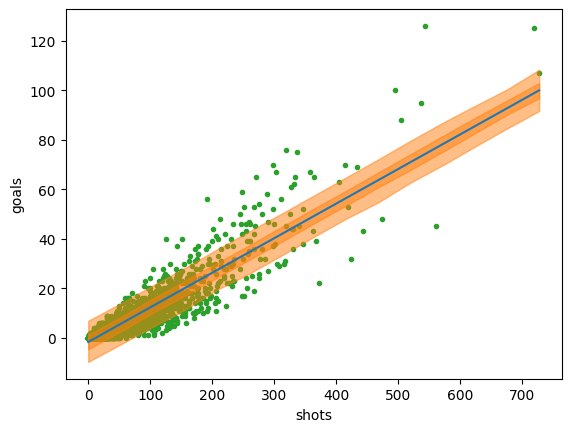

In [163]:
#plots the posterior predictive distribution

#grabs the expected line, or line of best fit formula
mean_line = idata_lfb.posterior["μ"].mean(("chain", "draw"))

#creates some x values to run through our line formula
shots = np.random.normal(football.shots.values, 0.01)
idx = np.argsort(shots)
x = np.linspace(shots.min(), shots.max(), 15)

#grabs the 94% HDI and 50% HDI, and sets them up for graphing.
y_pred_q = idata_lfb.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(shots[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(football.shots, football.goals, "C2.", zorder=-3)
ax.plot(football.shots[idx], mean_line[idx], c="C0")


#graphs the 94% and 50% HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("shots")
ax.set_ylabel("goals")

##Linear Model 2 Analysis

We still have the blue line, the line of best fit, but now we have a shades region that shows where the data should fall given its line. The thin shaded region means the computer is more confident and the model is more precise, while the wider region shows more uncertainty.

The uncertainty is lowest around the middle, and increases as we get further away from the mean number of shots. This shows the model is pretty good at predicting for the average player, but might not be as amazing for the players that take very few or a lot of shots. Given that the data is mostly in the shaded region, the 94% HDI, our model does a pretty good job at predicting.

The key components of this model are similar to the first model, as they are quite similar, but the second model tests this model. It does this through the posterior predictive check, making it more reliable and more accurate with its depiction.

In [186]:
with pm.Model() as model_lgfb:
    # Priors for the linear model coefficients
    α = pm.Normal("α", mu=0, sigma=1)
    β = pm.Normal("β", mu=0, sigma=1)

    # Linear predictor with log-link to ensure positivity of mu
    mu = pm.Deterministic("mu", pm.math.exp(α + β * football.shots))

    # Prior for the standard deviation (sigma)
    sigma = pm.HalfCauchy("sigma", beta=10)  # Sigma must be positive

    # Likelihood: Gamma distribution
    y_pred = pm.Gamma("y_pred", mu=mu, sigma=sigma, observed=football.goals)

    # Sampling posterior
    idata_lgfb = pm.sample(1000, return_inferencedata=True, target_accept=0.9)


Output()

Output()

Text(0, 0.5, 'goals')

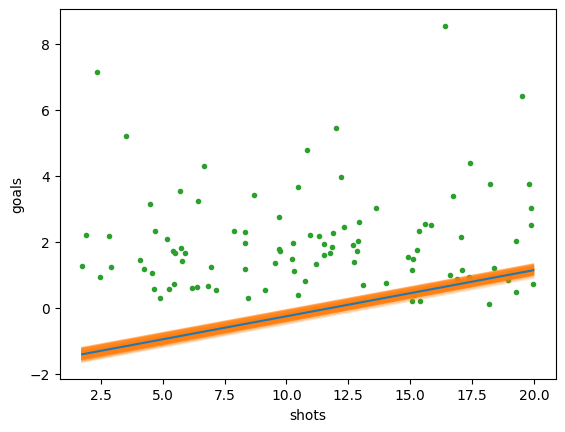

In [193]:
#grabs 100 posterior samples
posterior = az.extract(idata_lfb, num_samples=100)

# grabbing x values for graphing.
x_plot = xr.DataArray(
    np.linspace(football.shots.min(), football.shots.max(), 50),
    dims="plot_id"
    )

  # this creates the expected line, the path we predict temperature and
  #rented bike count deviates from
mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot

  #These are a 50 lines that our model came up with
lines = posterior["α"] + posterior["β"] * x_plot

  #set up plot
_, ax = plt.subplots()

  #plots 50 other lines our model came up with.
ax.plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")

  #plots the mean line
ax.plot(x_plot, mean_line, c="C0", label="mean line")

  #plot the raw data
ax.plot(football.shots, football.goals, "C2.", zorder=-3)

  #label axes and create legend
ax.set_xlabel("shots")
ax.set_ylabel("goals")

## Gamma model
This model is similar to the one before, but uses a gamma model to analyze the data. However, the data had A LOT of trouble staying positive, and its tendency to go negative is shown on the model. I struggled for the code to even run, as any negative values would cause an error, so it is not suprising that this error did eventually show up, but in the model. Negative values are bad because you literally cannot score negative goals, meaning this doesn't make much sense. Clearly, this model is not analyzing the data correctly, but if it was, I believe it would fit the data very well, considering how a gamma model looks and our data trend. If I had more time I would work on fixing this model, but this problem came up on the last day and I could not figure out a way that would work. Theoretically, I would fix the model by adding constraints that FORCE the values to stay postive, but I attempted that and they remained negative.

Let's assume this model worked and it maintained the key components a working gamma model would have: The line of best fit would not be perfectly straight, but instead would assume the "average" number of goals increases faster and faster as the shots increase, meaking the line curve. The model would have also not have any sort of negative numbers, as nobody can score -2 goals. However, this model failed to do so and therefore does not provide the most accurate representation of the data.

#summary
Our first model assumes the goals have a linear relationship to the number of shots. This model visualized the uncertainty in the model's parameters,with grey lines being narrower closer to the bottom and becoming more spread out as we continue. Our second model is similar to the first model but also is able to capture more uncertainty. This makes it a much better fit for the data, allowing us to analyze the data trends more accurately. Finally, the 3rd model attempted to show a gamma model, but failed due to negative values which did not make sense considering one cannot score negative goals. If this model had worked it most likely would have worked well with the data and shown the variation.